## Predicting news relevancy

In [1]:
# Basic ML things
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Tensorflow
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Other
import os

#### Loading the data

In [2]:
# Checking our data files.

DATA = './data'
print(os.listdir(DATA))

['test.csv', 'training-1.csv']


In [3]:
# Splitting data into train and validation sets.

all_df = pd.read_csv(os.path.join(DATA, 'training-1.csv'), index_col='id')

train_df, test_df = train_test_split(all_df, test_size=0.2)

print('Shape of train dataset = {}'.format(train_df.shape))
print('Shape of test dataset = {}'.format(test_df.shape))

train_df.head()

Shape of train dataset = (7534, 29)
Shape of test dataset = (1884, 29)


,age,app_type,owner_type,owner_influence,number_of_likes,number_of_comments,is_commented_by_connections,is_liked_by_me,is_liked_by_connections,poster_id,...,participant2_action,participant2_gender,participant2_focus,participant2_influence,participant3_id,participant3_action,participant3_gender,participant3_focus,participant3_influence,rank
id,,,,,,,,,,,,,,,,,,,,,
184121,5.632839e+10,calendar,space,0.10000,0,0,0,0,0,41,...,viewed,male,marketing,0.23077,44661,viewed,male,other,0.23077,0.49957
223901,3.026030e+10,other,user,0.98224,2,1,1,0,1,99314,...,liked,female,engineering,0.99613,22636,viewed,male,other,0.23077,0.79128
259240,1.148744e+10,other,space,0.10000,5,0,0,0,1,117086,...,liked,male,marketing,0.99788,41,liked,male,sales,0.99828,0.83280
222983,3.061241e+10,other,user,0.10000,1,1,0,0,0,108639,...,viewed,male,other,0.23077,3080,viewed,male,marketing,0.23077,0.66576
184103,5.633513e+10,other,space,0.99980,0,1,1,0,0,110965,...,viewed,male,other,0.23077,3080,viewed,male,marketing,0.23077,0.72201


In [4]:
test_df.to_csv(os.path.join(DATA, 'test.csv'))

### Exploratory Data Analysis

#### Checking missing values

In [5]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7534 entries, 184121 to 206303
Data columns (total 29 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   age                          7534 non-null   float64
 1   app_type                     7534 non-null   object 
 2   owner_type                   7534 non-null   object 
 3   owner_influence              7534 non-null   float64
 4   number_of_likes              7534 non-null   int64  
 5   number_of_comments           7534 non-null   int64  
 6   is_commented_by_connections  7534 non-null   int64  
 7   is_liked_by_me               7534 non-null   int64  
 8   is_liked_by_connections      7534 non-null   int64  
 9   poster_id                    7534 non-null   int64  
 10  poster_gender                7534 non-null   object 
 11  poster_focus                 7534 non-null   object 
 12  poster_influence             7534 non-null   float64
 13  participant

Luckily, we don't have any missing values. So there is no need to handle 'null's.

#### Exploring 'label' column

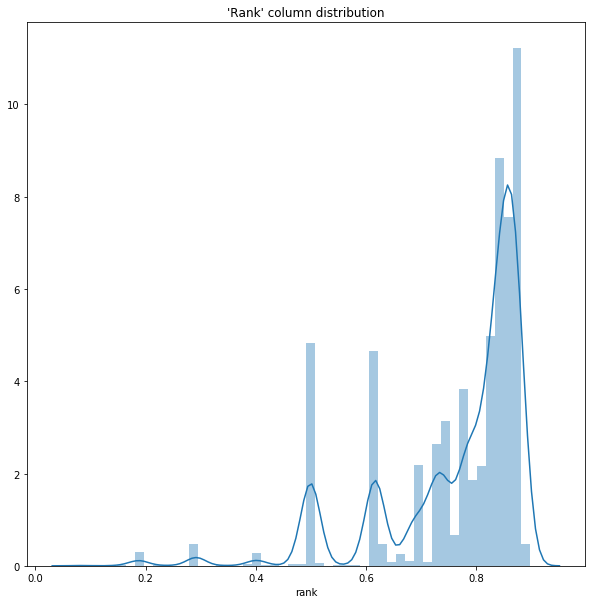

In [6]:
plt.figure(figsize=(10, 10))
plt.title("'Rank' column distribution")

sns.distplot(train_df['rank'])

Data does not follow normal distribution. Also we have some anomalous values at around 0.5 and 0.6 values.

#### Reviewing outliers

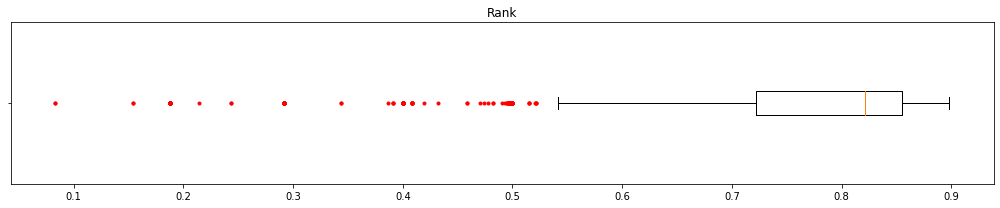

In [7]:
plt.figure(figsize=(14, 3))
plt.boxplot(x=train_df['rank'], vert=False, sym="r.")
plt.tick_params(labelleft=False)
plt.title('Rank')

plt.tight_layout()

We can see that we have many outliers, but none of them are typing or human errors (as all of them are in logical range between 0 and 1), so we do not need to process them. Those are the values that are just hard to get, but no impossible.

### Checking summary statistics

In [8]:
all_cols = [col for col in train_df.columns if col != 'rank']
num_cols = [col for col in all_cols if train_df[col].dtype in ['int64', 'float64']]
cat_cols = [col for col in all_cols if col not in num_cols]

print("Number columns: {}".format(num_cols), end="\n\n")
print("Categorical columns: {}".format(cat_cols))

Number columns: ['age', 'owner_influence', 'number_of_likes', 'number_of_comments', 'is_commented_by_connections', 'is_liked_by_me', 'is_liked_by_connections', 'poster_id', 'poster_influence', 'participant1_id', 'participant1_influence', 'participant2_id', 'participant2_influence', 'participant3_id', 'participant3_influence']

Categorical columns: ['app_type', 'owner_type', 'poster_gender', 'poster_focus', 'participant1_action', 'participant1_gender', 'participant1_focus', 'participant2_action', 'participant2_gender', 'participant2_focus', 'participant3_action', 'participant3_gender', 'participant3_focus']


#### Numerical columns

In [9]:
train_df[num_cols].describe().T

,count,mean,std,min,25%,50%,75%,max
age,7534.0,3.405744e+10,1.757597e+10,4.147070e+09,2.116740e+10,3.215689e+10,4.754463e+10,2.050660e+11
owner_influence,7534.0,7.797002e-01,3.661597e-01,1.000000e-01,7.435900e-01,9.992300e-01,9.997700e-01,9.999200e-01
number_of_likes,7534.0,4.424078e+00,6.930656e+00,0.000000e+00,0.000000e+00,2.000000e+00,6.000000e+00,6.400000e+01
number_of_comments,7534.0,1.681046e+00,3.963570e+00,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,1.450000e+02
is_commented_by_connections,7534.0,4.972126e-01,5.000254e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00
is_liked_by_me,7534.0,3.411203e-02,1.815290e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
is_liked_by_connections,7534.0,6.527741e-01,4.761199e-01,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
poster_id,7534.0,4.921191e+04,5.734877e+04,1.000000e+00,1.700000e+01,1.410000e+02,1.170860e+05,1.291040e+05
poster_influence,7534.0,9.649758e-01,1.523450e-01,9.091000e-02,9.958600e-01,9.980600e-01,9.989500e-01,9.996200e-01
participant1_id,7534.0,3.852296e+04,5.031662e+04,1.000000e+00,1.700000e+01,1.365900e+04,1.080250e+05,1.291040e+05


Columns {poster_id, participant1_id, participant2_id, participant3_id} are just identificators for users, it is unlikely that we get some useful insights from here without info about this users.

Columns {is_commented_by_connections, is_liked_by_me, is_liked_by_connections} are 'dummy' onehot variables, which can have only 2 values: 0 and 1.

#### Categorical columns

In [10]:
train_df[cat_cols].nunique()

app_type               6
owner_type             2
poster_gender          2
poster_focus           5
participant1_action    3
participant1_gender    2
participant1_focus     4
participant2_action    3
participant2_gender    2
participant2_focus     4
participant3_action    3
participant3_gender    2
participant3_focus     4
dtype: int64

All of the columns have no more than 6 unique values, so it is recommended to use one-hot encoding for them.

Also, let's take a closer look on this data to know better what we are dealing with.

In [11]:
print("Unique values in every categorical column:", end="\n\n")
for col in cat_cols:
    print("{:19s} --> {}".format(col, train_df[col].unique()))

Unique values in every categorical column:

app_type            --> ['calendar' 'other' 'wiki' 'forum' 'poll' 'social']
owner_type          --> ['space' 'user']
poster_gender       --> ['male' 'female']
poster_focus        --> ['sales' 'marketing' 'other' 'engineering' 'none']
participant1_action --> ['viewed' 'commented' 'liked']
participant1_gender --> ['male' 'female']
participant1_focus  --> ['other' 'marketing' 'engineering' 'sales']
participant2_action --> ['viewed' 'liked' 'commented']
participant2_gender --> ['male' 'female']
participant2_focus  --> ['marketing' 'engineering' 'other' 'sales']
participant3_action --> ['viewed' 'liked' 'commented']
participant3_gender --> ['male' 'female']
participant3_focus  --> ['other' 'sales' 'marketing' 'engineering']


Columns {poster_focus, participant1_focus, participant2_focus, participant3_focus} contain 'none' value. According to description of the data, we can change it to 'other' value.

## Preprocessing data

#### Modifying 'poster_focus' and 'participantN_focus' columns

In [12]:
mod_cols = ['poster_focus', 'participant1_focus', 'participant2_focus', 'participant3_focus']

for col in mod_cols:
    train_df[col] = train_df[col].apply(lambda row: 'other' if row == 'none' else row)
    print("{:18s} --> {}".format(col, train_df[col].unique()))

poster_focus       --> ['sales' 'marketing' 'other' 'engineering']
participant1_focus --> ['other' 'marketing' 'engineering' 'sales']
participant2_focus --> ['marketing' 'engineering' 'other' 'sales']
participant3_focus --> ['other' 'sales' 'marketing' 'engineering']


/home/dmkirichen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


#### One hot encoding

In [13]:
encoder = OneHotEncoder(handle_unknown='ignore')

encoder.fit(train_df[cat_cols].to_numpy())
rez = encoder.transform(train_df[cat_cols].to_numpy())
rez_df = pd.DataFrame(rez.toarray())
    
rez_df.index = train_df.index

new_feature_names = encoder.get_feature_names(cat_cols)
rename_to_new = {old: new for old, new in zip(list(range(41)), new_feature_names)}
rez_df = rez_df.rename(rename_to_new, axis=1)

rez_df.head()

,app_type_calendar,app_type_forum,app_type_other,app_type_poll,app_type_social,app_type_wiki,owner_type_space,owner_type_user,poster_gender_female,poster_gender_male,...,participant2_focus_sales,participant3_action_commented,participant3_action_liked,participant3_action_viewed,participant3_gender_female,participant3_gender_male,participant3_focus_engineering,participant3_focus_marketing,participant3_focus_other,participant3_focus_sales
id,,,,,,,,,,,,,,,,,,,,,
184121,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
223901,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
259240,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
222983,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
184103,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [14]:
train_enc_df = train_df.copy()
train_enc_df = train_enc_df.merge(rez_df, right_index=True, left_index=True, how='outer')
train_enc_df = train_enc_df.drop(cat_cols, axis=1)

train_enc_df.head()

,age,owner_influence,number_of_likes,number_of_comments,is_commented_by_connections,is_liked_by_me,is_liked_by_connections,poster_id,poster_influence,participant1_id,...,participant2_focus_sales,participant3_action_commented,participant3_action_liked,participant3_action_viewed,participant3_gender_female,participant3_gender_male,participant3_focus_engineering,participant3_focus_marketing,participant3_focus_other,participant3_focus_sales
id,,,,,,,,,,,,,,,,,,,,,
184121,5.632839e+10,0.10000,0,0,0,0,0,41,0.99828,22636,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
223901,3.026030e+10,0.98224,2,1,1,0,1,99314,0.99589,110401,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
259240,1.148744e+10,0.10000,5,0,0,0,1,117086,0.99161,6,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
222983,3.061241e+10,0.10000,1,1,0,0,0,108639,0.99436,119825,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
184103,5.633513e+10,0.99980,0,1,1,0,0,110965,0.99861,110965,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


In [15]:
train_enc_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7534 entries, 184121 to 206303
Data columns (total 57 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             7534 non-null   float64
 1   owner_influence                 7534 non-null   float64
 2   number_of_likes                 7534 non-null   int64  
 3   number_of_comments              7534 non-null   int64  
 4   is_commented_by_connections     7534 non-null   int64  
 5   is_liked_by_me                  7534 non-null   int64  
 6   is_liked_by_connections         7534 non-null   int64  
 7   poster_id                       7534 non-null   int64  
 8   poster_influence                7534 non-null   float64
 9   participant1_id                 7534 non-null   int64  
 10  participant1_influence          7534 non-null   float64
 11  participant2_id                 7534 non-null   int64  
 12  participant2_influence     

Everything looks correct.

#### Dropping redundant columns

In [16]:
drop_cols = ['poster_id', 'participant1_id', 'participant2_id', 'participant3_id']
train_enc_df = train_enc_df.drop(drop_cols, axis=1)
train_enc_df.head()

,age,owner_influence,number_of_likes,number_of_comments,is_commented_by_connections,is_liked_by_me,is_liked_by_connections,poster_influence,participant1_influence,participant2_influence,...,participant2_focus_sales,participant3_action_commented,participant3_action_liked,participant3_action_viewed,participant3_gender_female,participant3_gender_male,participant3_focus_engineering,participant3_focus_marketing,participant3_focus_other,participant3_focus_sales
id,,,,,,,,,,,,,,,,,,,,,
184121,5.632839e+10,0.10000,0,0,0,0,0,0.99828,0.23077,0.23077,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
223901,3.026030e+10,0.98224,2,1,1,0,1,0.99589,0.99788,0.99613,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
259240,1.148744e+10,0.10000,5,0,0,0,1,0.99161,0.99772,0.99788,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
222983,3.061241e+10,0.10000,1,1,0,0,0,0.99436,0.99754,0.23077,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
184103,5.633513e+10,0.99980,0,1,1,0,0,0.99861,0.99861,0.23077,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0


#### Feature Crosses

It will make sense to create new features, which represent combined features to improve training of our models.

I'll try to make feature that describes full influence of 'participant' on the relevance of the news.

In [17]:
train_mod_df = train_enc_df.copy()

participants = ['participant1', 'participant2', 'participant3']
actions = ['_commented', '_liked', '_viewed']
focuses = ['_engineering', '_marketing', '_sales', '_other']

for part in participants:
    for action in actions:
        for focus in focuses:
            train_mod_df[part + action + focus] = train_mod_df[part + '_action' + action] * \
                                                  train_mod_df[part + '_focus' + focus]
        
train_mod_df.head()

,age,owner_influence,number_of_likes,number_of_comments,is_commented_by_connections,is_liked_by_me,is_liked_by_connections,poster_influence,participant1_influence,participant2_influence,...,participant3_commented_sales,participant3_commented_other,participant3_liked_engineering,participant3_liked_marketing,participant3_liked_sales,participant3_liked_other,participant3_viewed_engineering,participant3_viewed_marketing,participant3_viewed_sales,participant3_viewed_other
id,,,,,,,,,,,,,,,,,,,,,
184121,5.632839e+10,0.10000,0,0,0,0,0,0.99828,0.23077,0.23077,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
223901,3.026030e+10,0.98224,2,1,1,0,1,0.99589,0.99788,0.99613,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
259240,1.148744e+10,0.10000,5,0,0,0,1,0.99161,0.99772,0.99788,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
222983,3.061241e+10,0.10000,1,1,0,0,0,0.99436,0.99754,0.23077,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
184103,5.633513e+10,0.99980,0,1,1,0,0,0.99861,0.99861,0.23077,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


Also, it makes sense to cross those new features with the influence of every related participant.

In [18]:
for part in participants:
    for action in actions:
        for focus in focuses:
            train_mod_df[part + action + focus + '_infl'] = train_mod_df[part + action + focus] * \
                                                            train_mod_df[part + '_influence']

train_mod_df.head()

,age,owner_influence,number_of_likes,number_of_comments,is_commented_by_connections,is_liked_by_me,is_liked_by_connections,poster_influence,participant1_influence,participant2_influence,...,participant3_commented_sales_infl,participant3_commented_other_infl,participant3_liked_engineering_infl,participant3_liked_marketing_infl,participant3_liked_sales_infl,participant3_liked_other_infl,participant3_viewed_engineering_infl,participant3_viewed_marketing_infl,participant3_viewed_sales_infl,participant3_viewed_other_infl
id,,,,,,,,,,,,,,,,,,,,,
184121,5.632839e+10,0.10000,0,0,0,0,0,0.99828,0.23077,0.23077,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.23077
223901,3.026030e+10,0.98224,2,1,1,0,1,0.99589,0.99788,0.99613,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.00000,0.0,0.23077
259240,1.148744e+10,0.10000,5,0,0,0,1,0.99161,0.99772,0.99788,...,0.0,0.0,0.0,0.0,0.99828,0.0,0.0,0.00000,0.0,0.00000
222983,3.061241e+10,0.10000,1,1,0,0,0,0.99436,0.99754,0.23077,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.23077,0.0,0.00000
184103,5.633513e+10,0.99980,0,1,1,0,0,0.99861,0.99861,0.23077,...,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.23077,0.0,0.00000


#### Normalizing data

Column 'age' has very large values, we need to rescale it for better training.

In [19]:
train_mod_df['age'] = (train_mod_df['age'] - train_mod_df['age'].mean()) / train_mod_df['age'].std()
train_mod_df['age'].describe()

count    7.534000e+03
mean     6.847898e-17
std      1.000000e+00
min     -1.701777e+00
25%     -7.333903e-01
50%     -1.081340e-01
75%      7.673654e-01
max      9.729681e+00
Name: age, dtype: float64

## Building model

In [20]:
n = train_mod_df.shape[1]  # number of features

model = Sequential([Dense(n, activation='relu', kernel_initializer='random_normal'), 
                    Dense(50, activation='relu'), 
                    Dense(1, activation='sigmoid')])

In [21]:
model.compile(loss='mse', optimizer='sgd', metrics=['mse'])

In [22]:
x_cols = [col for col in train_mod_df.columns if col != 'rank']

X = train_mod_df[x_cols].to_numpy()
y = train_mod_df['rank'].to_numpy()

model.fit(X, y, epochs=10, batch_size=10)

Train on 7534 samples
Epoch 1/10
7534/7534 [==============================] - 4s 503us/sample - loss: 0.0077 - mse: 0.0077
Epoch 2/10
7534/7534 [==============================] - 3s 421us/sample - loss: 0.0030 - mse: 0.0030
Epoch 3/10
7534/7534 [==============================] - 3s 437us/sample - loss: 0.0023 - mse: 0.0023
Epoch 4/10
7534/7534 [==============================] - 3s 423us/sample - loss: 0.0019 - mse: 0.0019
Epoch 5/10
7534/7534 [==============================] - 3s 413us/sample - loss: 0.0017 - mse: 0.0017
Epoch 6/10
7534/7534 [==============================] - 3s 382us/sample - loss: 0.0015 - mse: 0.0015
Epoch 7/10
7534/7534 [==============================] - 3s 417us/sample - loss: 0.0014 - mse: 0.0014
Epoch 8/10
7534/7534 [==============================] - 3s 422us/sample - loss: 0.0014 - mse: 0.0014
Epoch 9/10
7534/7534 [==============================] - 3s 463us/sample - loss: 0.0013 - mse: 0.0013
Epoch 10/10
7534/7534 [==============================] - 3s 431us/sam

In [23]:
# Saving the model

model.save('model.h5')

### Predicting new values

In [24]:
def predict(filename):
    """
    Function for preprocessing new data and predicting 'rank' values, using trained model.
    """
    
    df = pd.read_csv(os.path.join(DATA, filename))
    
    # Changing some of the focus columns
    for col in mod_cols:
        df[col] = df[col].apply(lambda row: 'other' if row == 'none' else row)
    
    # One hot encoding 
    rez = encoder.transform(df[cat_cols].to_numpy())
    rez_df = pd.DataFrame(rez.toarray())
    
    rez_df.index = df.index
    new_feature_names = encoder.get_feature_names(cat_cols)
    rename_to_new = {old: new for old, new in zip(list(range(41)), new_feature_names)}
    rez_df = rez_df.rename(rename_to_new, axis=1)

    enc_df = df.copy()
    enc_df = enc_df.merge(rez_df, right_index=True, left_index=True, how='outer')
    enc_df = enc_df.drop(cat_cols, axis=1)

    # Dropping redundant columns
    enc_df = enc_df.drop(drop_cols, axis=1)

    # Creating new features (feature cross)
    mod_df = enc_df.copy()

    for part in participants:
        for action in actions:
            for focus in focuses:
                mod_df[part + action + focus] = mod_df[part + '_action' + action] * \
                                                mod_df[part + '_focus' + focus]
                mod_df[part + action + focus + '_infl'] = mod_df[part + action + focus] * \
                                                          mod_df[part + '_influence']

    # Rescaling 'age' column
    mod_df['age'] = (mod_df['age'] - mod_df['age'].mean()) / mod_df['age'].std()
    
    # Using the model
    X = mod_df[x_cols].to_numpy()
    y = model.predict(X)
    return y

In [25]:
y_pred = predict('test.csv')

In [26]:
# Checking with real answers

y = pd.read_csv(os.path.join(DATA, 'test.csv'))['rank'].to_numpy().reshape(-1, 1)

In [27]:
# Calculating MSE for test data

mse = np.sum((y - y_pred) ** 2) / len(y)
print(mse)

0.001444583073166617
